In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy
from tqdm import tqdm

In [26]:
def data_creating():
    data=[]
    DATADIR="C:/PetImages"
    CATEGORIES={ "Cat":0, "Dog":1}
    IMG_SIZE=32
    
    for ke,val in CATEGORIES.items():
        path_to_datas= os.path.join(DATADIR, ke)
        class_num= val
        for img in os.listdir(path_to_datas):
            try:
                img_arr= cv2.imread(os.path.join(path_to_datas, img), cv2.IMREAD_GRAYSCALE)
                new_arr= cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
                data.append([new_arr, class_num])
            except Exception as e:
                pass
    random.shuffle(data)
    x_data=[]
    y_data=[]
    
    for features , labels in data:
        x_data.append(features)
        y_data.append(labels)
    x_data= np.array(x_data).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    y_data=np.array(y_data)
    
    pickle_out= open("x_data.pickle", "wb")
    pickle.dump(x_data, pickle_out)
    pickle_out.close()
    
    pickle_out= open("y_data.pickle", "wb")
    pickle.dump(y_data, pickle_out)
    pickle_out.close()
    print("x_data.pickle when opening features ======== y_data.pickle for labels ")
    
    

In [27]:
data_creating()

x_data.pickle when opening features ======== y_data.pickle for labels 


In [28]:
def load_data():
    pickle_in= open("x_data.pickle" ,"rb")
    features=pickle.load(pickle_in)

    pickle_in= open("y_data.pickle" ,"rb")
    labels=pickle.load(pickle_in)
    return(features, labels)


In [47]:
features, labels=load_data()
features.shape

(24946, 32, 32, 1)

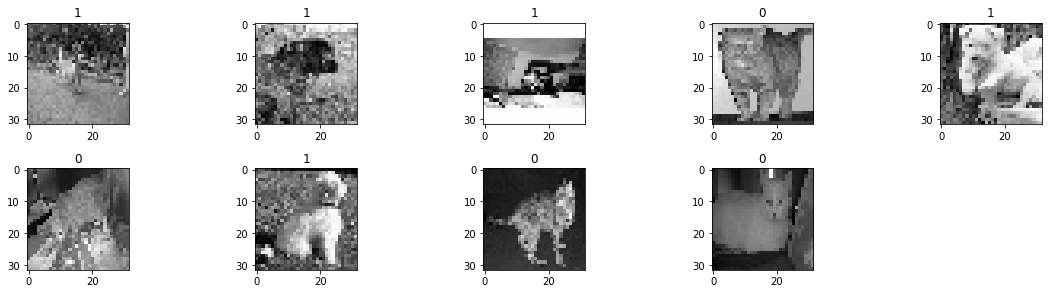

In [48]:
plt.figure(figsize=(16, 8))
for i in range(1, 11):
    plt.subplot(4, 5, i)
    plt.imshow(features[i], cmap='gray')
    plt.title(labels[i])
    plt.tight_layout()
plt.show()

In [49]:
features= features.astype(np.float32)

In [50]:
#normalisation
features= features/255.0


In [85]:
#decoupage
f_train, f_valid, label_train, label_valid= train_test_split(features, labels, test_size=0.2, random_state=0)

f_train= f_train[0:1000]
f_valid= f_valid[0:100]
label_train= label_train[0:1000]
label_valid= label_valid[0:100]



In [86]:
#utilisation de tf.data
train_data = tf.data.Dataset.from_tensor_slices((f_train, label_train))
valid_data= tf.data.Dataset.from_tensor_slices((f_valid, label_valid))

In [87]:
# customization du modele
class cnn_DC(tf.keras.Model):
    def __init__(self):
        super(cnn_DC, self).__init__()
        #defining our layers
        self.conv1= Conv2D(64, 5, activation="relu", name="conv1")
        self.conv2= Conv2D(128,4, activation="relu", name="con2")
        self.conv3= Conv2D(256,3, activation="relu", name="con2")
        self.flatten= Flatten()
        self.Dense1= Dense(256, activation="relu", name="dense1")
        self.Dense2= Dense(2, activation="softmax" , name="dense2")
        
    def call(self, features):
        conv1=self.conv1(features)
        conv2= self.conv2(conv1)
        conv3= self.conv3(conv2)
        flatten=self.flatten(conv3)
        dense1= self.Dense1(flatten)
        dense2= self.Dense2(dense1)
        return dense2
    
#instanciate a new convolutional neural network
cnn_model=cnn_DC()
        
    

In [88]:
#set the losses , optimizers , metrics and accuracies

#losses
loss_object= SparseCategoricalCrossentropy()

#optimizers
optimizer=Adam()

#metrics
train_loss= Mean(name="train_loss")
valid_loss= Mean(name="valid_loss")


#accuracies
train_acc= SparseCategoricalAccuracy(name="train_acc")
valid_acc= SparseCategoricalAccuracy(name="valid_acc")



In [89]:
# custom trainning model
@tf.function #using graph for fast trainning
def train_step(features, targets):
    with tf.GradientTape() as tape:
        predictions=cnn_model(features)
        loss= loss_object( targets, predictions)
        #fetch gradients
    gradients= tape.gradient(loss, cnn_model.trainable_variables)
    #optimize parameters for each gradients
    optimizer.apply_gradients(zip(gradients, cnn_model.trainable_variables))
    #loss and acc
    train_loss(loss)
    train_acc(targets, predictions)
    
    
    

In [90]:
#custom validation test
@tf.function
def validation_test(features, targets):
    predictions= cnn_model(features)
    loss= loss_object(targets, predictions)
    
    valid_loss(loss)
    valid_acc(targets, predictions)

In [93]:
epochs=6
b=0
batch_size=12
train_curve=[]
valid_curve=[]
for epoch in range( epochs):
    b=0
    for features_batch, labels_batch in train_data.batch(batch_size):
        train_step(features_batch, labels_batch)
        print("Epoch: ",b,"/", len(train_data),"  LOSS-TEST:",train_loss.result(),"   ACC-TEST:", train_acc.result()*100,"\n")
        train_curve.append(train_acc.result())
        b+= batch_size
    for features_batch, labels_batch in valid_data.batch(batch_size):
        validation_test(features_batch, labels_batch)
        print("Epoch:",epoch+1,"   LOSS-VAL: ",valid_loss.result(),"   ACC-VAL: ", valid_acc.result()*100,"\n")
        valid_curve.append(valid_acc.result())
    valid_acc.reset_states()
    valid_loss.reset_states()
    train_acc.reset_states()
    train_loss.reset_states()
              

Epoch:  0 / 1000   LOSS-TEST: tf.Tensor(0.69892615, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(33.333336, shape=(), dtype=float32) 

Epoch:  12 / 1000   LOSS-TEST: tf.Tensor(0.6740459, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(54.166668, shape=(), dtype=float32) 

Epoch:  24 / 1000   LOSS-TEST: tf.Tensor(0.67562634, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(58.333332, shape=(), dtype=float32) 

Epoch:  36 / 1000   LOSS-TEST: tf.Tensor(0.68448615, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(54.166668, shape=(), dtype=float32) 

Epoch:  48 / 1000   LOSS-TEST: tf.Tensor(0.68108064, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(58.333332, shape=(), dtype=float32) 

Epoch:  60 / 1000   LOSS-TEST: tf.Tensor(0.67646813, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(61.11111, shape=(), dtype=float32) 

Epoch:  72 / 1000   LOSS-TEST: tf.Tensor(0.6777741, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(60.714287, shape=(), dtype=float32) 

Epoch:  84 / 1000   LOSS-TEST: 

Epoch:  720 / 1000   LOSS-TEST: tf.Tensor(0.69607633, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(52.04918, shape=(), dtype=float32) 

Epoch:  732 / 1000   LOSS-TEST: tf.Tensor(0.6959497, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(52.150536, shape=(), dtype=float32) 

Epoch:  744 / 1000   LOSS-TEST: tf.Tensor(0.69590783, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(52.1164, shape=(), dtype=float32) 

Epoch:  756 / 1000   LOSS-TEST: tf.Tensor(0.69605505, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(51.822918, shape=(), dtype=float32) 

Epoch:  768 / 1000   LOSS-TEST: tf.Tensor(0.6960453, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(51.666664, shape=(), dtype=float32) 

Epoch:  780 / 1000   LOSS-TEST: tf.Tensor(0.6960282, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(51.515152, shape=(), dtype=float32) 

Epoch:  792 / 1000   LOSS-TEST: tf.Tensor(0.69603544, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(51.243782, shape=(), dtype=float32) 

Epoch:  804 / 1000   LOSS-

Epoch:  324 / 1000   LOSS-TEST: tf.Tensor(0.693243, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(49.404762, shape=(), dtype=float32) 

Epoch:  336 / 1000   LOSS-TEST: tf.Tensor(0.69326043, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(49.13793, shape=(), dtype=float32) 

Epoch:  348 / 1000   LOSS-TEST: tf.Tensor(0.69332945, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(48.055557, shape=(), dtype=float32) 

Epoch:  360 / 1000   LOSS-TEST: tf.Tensor(0.69332373, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(48.11828, shape=(), dtype=float32) 

Epoch:  372 / 1000   LOSS-TEST: tf.Tensor(0.6933018, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(48.4375, shape=(), dtype=float32) 

Epoch:  384 / 1000   LOSS-TEST: tf.Tensor(0.69326633, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(48.9899, shape=(), dtype=float32) 

Epoch:  396 / 1000   LOSS-TEST: tf.Tensor(0.69327813, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(48.77451, shape=(), dtype=float32) 

Epoch:  408 / 1000   LOSS-TEST

Epoch: 2    LOSS-VAL:  tf.Tensor(0.6945389, shape=(), dtype=float32)    ACC-VAL:  tf.Tensor(41.666664, shape=(), dtype=float32) 

Epoch: 2    LOSS-VAL:  tf.Tensor(0.6943691, shape=(), dtype=float32)    ACC-VAL:  tf.Tensor(42.708336, shape=(), dtype=float32) 

Epoch: 2    LOSS-VAL:  tf.Tensor(0.69378424, shape=(), dtype=float32)    ACC-VAL:  tf.Tensor(44.0, shape=(), dtype=float32) 

Epoch:  0 / 1000   LOSS-TEST: tf.Tensor(0.6931804, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(50.0, shape=(), dtype=float32) 

Epoch:  12 / 1000   LOSS-TEST: tf.Tensor(0.69246894, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(54.166668, shape=(), dtype=float32) 

Epoch:  24 / 1000   LOSS-TEST: tf.Tensor(0.6937085, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(47.22222, shape=(), dtype=float32) 

Epoch:  36 / 1000   LOSS-TEST: tf.Tensor(0.69357884, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(47.916664, shape=(), dtype=float32) 

Epoch:  48 / 1000   LOSS-TEST: tf.Tensor(0.6938174, shape=(), dtype

Epoch:  684 / 1000   LOSS-TEST: tf.Tensor(0.69341016, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(48.99425, shape=(), dtype=float32) 

Epoch:  696 / 1000   LOSS-TEST: tf.Tensor(0.693453, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(48.58757, shape=(), dtype=float32) 

Epoch:  708 / 1000   LOSS-TEST: tf.Tensor(0.69341815, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(48.88889, shape=(), dtype=float32) 

Epoch:  720 / 1000   LOSS-TEST: tf.Tensor(0.6934139, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(48.907104, shape=(), dtype=float32) 

Epoch:  732 / 1000   LOSS-TEST: tf.Tensor(0.6934243, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(48.790325, shape=(), dtype=float32) 

Epoch:  744 / 1000   LOSS-TEST: tf.Tensor(0.6934201, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(48.80952, shape=(), dtype=float32) 

Epoch:  756 / 1000   LOSS-TEST: tf.Tensor(0.6933888, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(49.08854, shape=(), dtype=float32) 

Epoch:  768 / 1000   LOSS-TEST:

Epoch:  288 / 1000   LOSS-TEST: tf.Tensor(0.693869, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(47.666664, shape=(), dtype=float32) 

Epoch:  300 / 1000   LOSS-TEST: tf.Tensor(0.69384426, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(47.75641, shape=(), dtype=float32) 

Epoch:  312 / 1000   LOSS-TEST: tf.Tensor(0.69366974, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(48.45679, shape=(), dtype=float32) 

Epoch:  324 / 1000   LOSS-TEST: tf.Tensor(0.6934363, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(49.404762, shape=(), dtype=float32) 

Epoch:  336 / 1000   LOSS-TEST: tf.Tensor(0.6934994, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(49.13793, shape=(), dtype=float32) 

Epoch:  348 / 1000   LOSS-TEST: tf.Tensor(0.6937369, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(48.055557, shape=(), dtype=float32) 

Epoch:  360 / 1000   LOSS-TEST: tf.Tensor(0.6937202, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(48.11828, shape=(), dtype=float32) 

Epoch:  372 / 1000   LOSS-TEST

Epoch: 4    LOSS-VAL:  tf.Tensor(0.6908106, shape=(), dtype=float32)    ACC-VAL:  tf.Tensor(58.333332, shape=(), dtype=float32) 

Epoch: 4    LOSS-VAL:  tf.Tensor(0.69325465, shape=(), dtype=float32)    ACC-VAL:  tf.Tensor(50.0, shape=(), dtype=float32) 

Epoch: 4    LOSS-VAL:  tf.Tensor(0.6956987, shape=(), dtype=float32)    ACC-VAL:  tf.Tensor(41.666664, shape=(), dtype=float32) 

Epoch: 4    LOSS-VAL:  tf.Tensor(0.6956987, shape=(), dtype=float32)    ACC-VAL:  tf.Tensor(41.666664, shape=(), dtype=float32) 

Epoch: 4    LOSS-VAL:  tf.Tensor(0.6961875, shape=(), dtype=float32)    ACC-VAL:  tf.Tensor(40.0, shape=(), dtype=float32) 

Epoch: 4    LOSS-VAL:  tf.Tensor(0.69529134, shape=(), dtype=float32)    ACC-VAL:  tf.Tensor(43.055553, shape=(), dtype=float32) 

Epoch: 4    LOSS-VAL:  tf.Tensor(0.6956987, shape=(), dtype=float32)    ACC-VAL:  tf.Tensor(41.666664, shape=(), dtype=float32) 

Epoch: 4    LOSS-VAL:  tf.Tensor(0.69539315, shape=(), dtype=float32)    ACC-VAL:  tf.Tensor(42.70

Epoch:  612 / 1000   LOSS-TEST: tf.Tensor(0.6937722, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(48.237183, shape=(), dtype=float32) 

Epoch:  624 / 1000   LOSS-TEST: tf.Tensor(0.69379795, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(48.11321, shape=(), dtype=float32) 

Epoch:  636 / 1000   LOSS-TEST: tf.Tensor(0.6938216, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(47.993828, shape=(), dtype=float32) 

Epoch:  648 / 1000   LOSS-TEST: tf.Tensor(0.6937132, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(48.484848, shape=(), dtype=float32) 

Epoch:  660 / 1000   LOSS-TEST: tf.Tensor(0.6936088, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(48.958336, shape=(), dtype=float32) 

Epoch:  672 / 1000   LOSS-TEST: tf.Tensor(0.6936017, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(48.97661, shape=(), dtype=float32) 

Epoch:  684 / 1000   LOSS-TEST: tf.Tensor(0.6935948, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(48.99425, shape=(), dtype=float32) 

Epoch:  696 / 1000   LOSS-TES

Epoch:  216 / 1000   LOSS-TEST: tf.Tensor(0.6939533, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(48.245613, shape=(), dtype=float32) 

Epoch:  228 / 1000   LOSS-TEST: tf.Tensor(0.69406766, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(47.916664, shape=(), dtype=float32) 

Epoch:  240 / 1000   LOSS-TEST: tf.Tensor(0.6937543, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(48.80952, shape=(), dtype=float32) 

Epoch:  252 / 1000   LOSS-TEST: tf.Tensor(0.6936019, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(49.242424, shape=(), dtype=float32) 

Epoch:  264 / 1000   LOSS-TEST: tf.Tensor(0.6938405, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(48.550724, shape=(), dtype=float32) 

Epoch:  276 / 1000   LOSS-TEST: tf.Tensor(0.6941719, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(47.569447, shape=(), dtype=float32) 

Epoch:  288 / 1000   LOSS-TEST: tf.Tensor(0.6941367, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(47.666664, shape=(), dtype=float32) 

Epoch:  300 / 1000   LOSS-T

Epoch:  936 / 1000   LOSS-TEST: tf.Tensor(0.6932607, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(50.527424, shape=(), dtype=float32) 

Epoch:  948 / 1000   LOSS-TEST: tf.Tensor(0.6931752, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(50.729168, shape=(), dtype=float32) 

Epoch:  960 / 1000   LOSS-TEST: tf.Tensor(0.6932117, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(50.617283, shape=(), dtype=float32) 

Epoch:  972 / 1000   LOSS-TEST: tf.Tensor(0.6932127, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(50.609756, shape=(), dtype=float32) 

Epoch:  984 / 1000   LOSS-TEST: tf.Tensor(0.6931788, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(50.702812, shape=(), dtype=float32) 

Epoch:  996 / 1000   LOSS-TEST: tf.Tensor(0.6930753, shape=(), dtype=float32)    ACC-TEST: tf.Tensor(50.800003, shape=(), dtype=float32) 

Epoch: 6    LOSS-VAL:  tf.Tensor(0.6903923, shape=(), dtype=float32)    ACC-VAL:  tf.Tensor(58.333332, shape=(), dtype=float32) 

Epoch: 6    LOSS-VAL:  tf.Tensor(0.6

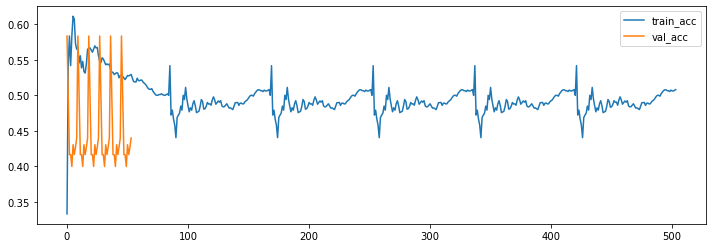

In [94]:

plt.figure(figsize=(12,4))
plt.plot(train_curve, label="train_acc")
plt.plot(valid_curve, label="val_acc")
plt.legend()


# beaucoup